In [1]:
import torch
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

from einops import rearrange, reduce, repeat
from pathlib import Path

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv
from bliss.catalog import TileCatalog, convert_flux_to_magnitude
from bliss.surveys.dc2 import DC2DataModule
from case_studies.dc2_mdt.utils.flow_matching_encoder import DC2FMEncoder

In [2]:
# model_path = "../../../bliss_output/dc2_mdt_flow_matching_exp_08-15-17-10-53_encoder_399.ckpt"
# cached_data_path =  Path("/data/scratch/pduan/posterior_cached_files")
# device = torch.device("cuda:3")
# with initialize(config_path="./mdt_config", version_base=None):
#     cfg = compose("mdt_flow_matching_train_config")

In [3]:
model_path = "../../../bliss_output/DC2_mdt_flow_matching_exp/exp_08-16-2/checkpoints/schedule_saved_encoder_149.ckpt"
cached_data_path =  Path("/data/scratch/pduan/posterior_cached_files")
device = torch.device("cuda:3")
with initialize(config_path="./mdt_config", version_base=None):
    cfg = compose("mdt_flow_matching_train_config")

In [4]:
seed = cfg.train.seed
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [5]:
batch_size = 300
dc2: DC2DataModule = instantiate(cfg.surveys.dc2)
dc2.batch_size = batch_size
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

In [6]:
cfg.encoder.d_flow_matching_type = "stochastic"

In [7]:
my_encoder: DC2FMEncoder = instantiate(cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
my_encoder.load_state_dict(pretrained_weights)
my_encoder.eval();

In [8]:
max_fluxes = my_encoder.max_fluxes
print(max_fluxes)

22025.0


In [9]:
# cached_file_name = f"m2_mdt_rml_df_posterior_" \
#                         f"{model_name}_{model_check_point_name}_" \
#                         f"ddim_steps_{ddim_sampling_steps}_" \
#                         f"eta_{ddim_eta:.1f}_" \
#                         f"seed_{seed}.pt"
# save_path = cached_data_path / cached_file_name
# if not os.path.isfile(save_path):
#     print(f"can't find cached file [{cached_file_name}]; rerun the inference")

diffusion_result_dict = {
    "pred_n_sources_list": [],
    "pred_locs_list": [],
    "pred_fluxes_list": [],
    "target1_n_sources_list": [],
    "target1_locs_list": [],
    "target1_fluxes_list": [],
    "target2_n_sources_list": [],
    "target2_locs_list": [],
    "target2_fluxes_list": [],
}

for one_batch in tqdm.tqdm(dc2_val_dataloader):
    one_batch = move_data_to_device(one_batch, device=device)

    target_tile_cat = TileCatalog(one_batch["tile_catalog"])
    target_cat1 = target_tile_cat.get_brightest_sources_per_tile(
        band=0, exclude_num=0
    )
    target_cat2 = target_tile_cat.get_brightest_sources_per_tile(
        band=0, exclude_num=1
    )
    diffusion_result_dict["target1_n_sources_list"].append(target_cat1["n_sources"].cpu())
    diffusion_result_dict["target1_locs_list"].append(target_cat1["locs"].cpu())
    diffusion_result_dict["target1_fluxes_list"].append(target_cat1["fluxes"].clamp(max=max_fluxes).cpu())
    diffusion_result_dict["target2_n_sources_list"].append(target_cat2["n_sources"].cpu())
    diffusion_result_dict["target2_locs_list"].append(target_cat2["locs"].cpu())
    diffusion_result_dict["target2_fluxes_list"].append(target_cat2["fluxes"].clamp(max=max_fluxes).cpu())

    with torch.inference_mode():
        # sample_tile_cat = my_encoder.sample(one_batch)
        # sample_tile_cat = my_encoder.sample(one_batch, ode_config_dict={
        #     "atol": 1e-4,
        #     "rtol": 1e-4,
        #     "method": "euler",
        #     "options": {
        #         "step_size": 0.1
        #     }
        # })
        sample_tile_cat = my_encoder.sample(one_batch, sde_config_dict={
            "dt": 0.01,
            "method": "euler",
            "atol": 1e-4,
            "rtol": 1e-4,
        })

    diffusion_result_dict["pred_n_sources_list"].append(sample_tile_cat["n_sources"].cpu())
    diffusion_result_dict["pred_locs_list"].append(sample_tile_cat["locs"].cpu())  # (b, h, w, 2, 2)
    diffusion_result_dict["pred_fluxes_list"].append(sample_tile_cat["fluxes"].cpu())  # (b, h, w, 2, 6)

#     torch.save(diffusion_result_dict, save_path)
# else:
#     print(f"find the cached file [{cached_file_name}]; run nothing")
#     with open(cached_data_path / cached_file_name, "rb") as f:
#         diffusion_result_dict = torch.load(f, map_location="cpu")

100%|██████████| 84/84 [33:10<00:00, 23.70s/it]


In [10]:
# save_path = "/data/scratch/pduan/posterior_cached_files/m2_flow_matching_posterior_exp_07-31-1_encoder_240.pt"
# if not os.path.isfile(save_path):
#     torch.save(diffusion_result_dict, save_path)
# else:
#     with open(save_path, "rb") as f:
#         diffusion_result_dict = torch.load(f, map_location="cpu")

In [11]:
# save_path = "/data/scratch/pduan/posterior_cached_files/m2_flow_matching_posterior_exp_07-31-1_encoder_395.pt"
# if not os.path.isfile(save_path):
#     torch.save(diffusion_result_dict, save_path)

In [12]:
# save_path = "/data/scratch/pduan/posterior_cached_files/m2_flow_matching_posterior_exp_07-31-1_encoder_395.pt"
# diffusion_result_dict = torch.load(save_path, map_location="cpu")

In [13]:
for k, v in diffusion_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([300, 20, 20])
pred_locs_list[0]: torch.Size([300, 20, 20, 2, 2])
pred_fluxes_list[0]: torch.Size([300, 20, 20, 2, 6])
target1_n_sources_list[0]: torch.Size([300, 20, 20])
target1_locs_list[0]: torch.Size([300, 20, 20, 1, 2])
target1_fluxes_list[0]: torch.Size([300, 20, 20, 1, 6])
target2_n_sources_list[0]: torch.Size([300, 20, 20])
target2_locs_list[0]: torch.Size([300, 20, 20, 1, 2])
target2_fluxes_list[0]: torch.Size([300, 20, 20, 1, 6])


In [14]:
with open(cached_data_path / "bliss_posterior_exp_03-30-2_encoder_39.ckpt_whole_val_set_seed_7272.pt", "rb") as f:
    bliss_result_dict = torch.load(f, map_location="cpu")

In [15]:
for k, v in bliss_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([800, 20, 20])
pred_locs_list[0]: torch.Size([800, 20, 20, 2, 2])
pred_fluxes_list[0]: torch.Size([800, 20, 20, 2, 6])
target1_n_sources_list[0]: torch.Size([800, 20, 20])
target1_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target1_fluxes_list[0]: torch.Size([800, 20, 20, 1, 6])
target2_n_sources_list[0]: torch.Size([800, 20, 20])
target2_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target2_fluxes_list[0]: torch.Size([800, 20, 20, 1, 6])


## N Sources CM

In [16]:
diffusion_true_ns = []
diffusion_pred_ns = []
for true1_ns, true2_ns, pred_ns in zip(diffusion_result_dict["target1_n_sources_list"],
                                        diffusion_result_dict["target2_n_sources_list"],
                                        diffusion_result_dict["pred_n_sources_list"],
                                        strict=True):
    diffusion_pred_ns.append(pred_ns)
    diffusion_true_ns.append(true1_ns + true2_ns)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)

In [17]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([25000, 20, 20]), torch.Size([25000, 20, 20]))

In [18]:
bliss_true_ns = []
bliss_pred_ns = []
for true1_ns, true2_ns, pred_ns in zip(bliss_result_dict["target1_n_sources_list"],
                                        bliss_result_dict["target2_n_sources_list"],
                                        bliss_result_dict["pred_n_sources_list"],
                                        strict=True):
    bliss_pred_ns.append(pred_ns)
    bliss_true_ns.append(true1_ns + true2_ns)
bliss_true_ns = torch.cat(bliss_true_ns, dim=0)
bliss_pred_ns = torch.cat(bliss_pred_ns, dim=0)

In [19]:
bliss_true_ns.shape, bliss_pred_ns.shape

(torch.Size([25000, 20, 20]), torch.Size([25000, 20, 20]))

In [20]:
def plot_cm(d_pred_bin_index, 
            d_true_bin_index,
            b_pred_bin_index,
            b_true_bin_index,
            bin_num, 
            bin_labels, 
            axis_label,
            exclude_first_and_last_bins=False):
    d_cm = torch.zeros(bin_num, bin_num, dtype=torch.int)
    for ri in range(d_cm.shape[0]):
        for ci in range(d_cm.shape[1]):
            d_cm[ri, ci] = ((d_pred_bin_index == ri) & (d_true_bin_index == ci)).sum()
    b_cm = torch.zeros(bin_num, bin_num, dtype=torch.int)
    for ri in range(b_cm.shape[0]):
        for ci in range(b_cm.shape[1]):
            b_cm[ri, ci] = ((b_pred_bin_index == ri) & (b_true_bin_index == ci)).sum()
    if exclude_first_and_last_bins:
        d_cm = d_cm[1:-1, 1:-1]
        b_cm = b_cm[1:-1, 1:-1]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[0])
    axes[0].set_xlabel(f"True {axis_label}")
    axes[0].set_ylabel(f"Pred {axis_label}")
    axes[0].set_title("FM")
    sns.heatmap(b_cm,
                annot=True,
                fmt="d", cmap="Blues", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[1])
    axes[1].set_xlabel(f"True {axis_label}")
    axes[1].set_ylabel(f"Pred {axis_label}")
    axes[1].set_title("BLISS")
    fig.show()

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    d_cm_af = (d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)
    sns.heatmap(d_cm_af.abs(),
                annot=d_cm_af,
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[0])
    axes[0].set_xlabel(f"True {axis_label}")
    axes[0].set_ylabel(f"Pred {axis_label}")
    d_af = ((d_cm - d_cm.T) / d_cm.sum()).abs().sum() / (bin_num * (bin_num - 1))
    axes[0].set_title(f"FM (Asymmetry Factor = {d_af:.2e})")
    b_cm_af = (b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1)
    sns.heatmap(b_cm_af.abs(),
                annot=b_cm_af,
                fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=axes[1])
    axes[1].set_xlabel(f"True {axis_label}")
    axes[1].set_ylabel(f"Pred {axis_label}")
    b_af = ((b_cm - b_cm.T) / b_cm.sum()).abs().sum() / (bin_num * (bin_num - 1))
    axes[1].set_title(f"BLISS (Asymmetry Factor = {b_af:.2e})")
    fig.show()

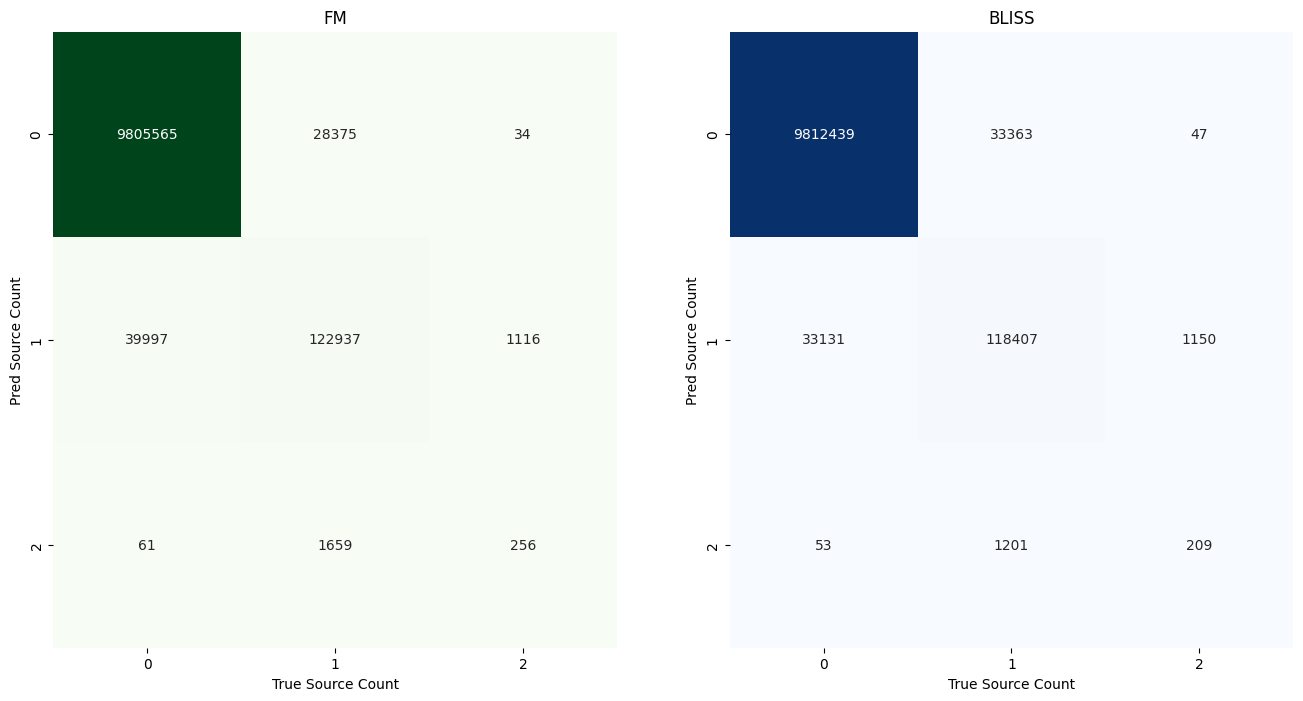

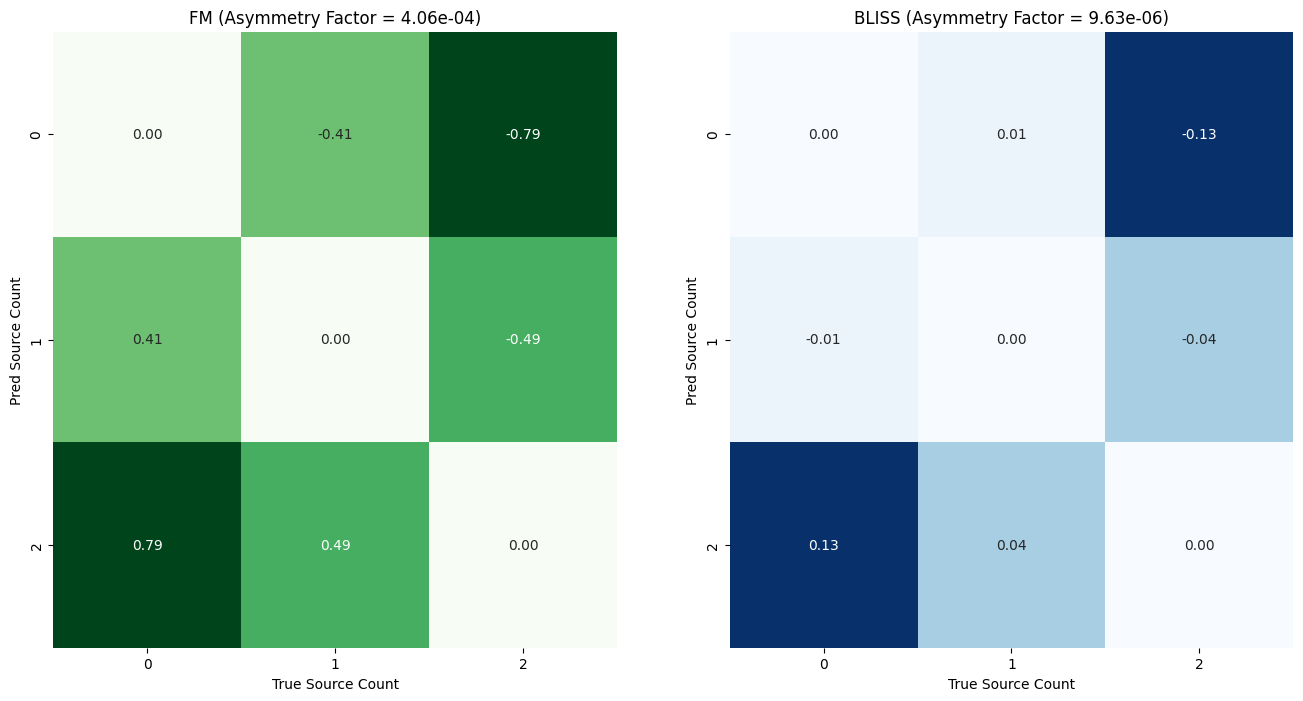

In [21]:
plot_cm(diffusion_pred_ns, diffusion_true_ns,
        bliss_pred_ns, bliss_true_ns,
        bin_num=3, bin_labels=list(range(3)), axis_label="Source Count")

## Locs

In [22]:
diffusion_true_locs = []
diffusion_pred_locs = []
for true1_locs, true2_locs, pred_locs in zip(diffusion_result_dict["target1_locs_list"],
                                             diffusion_result_dict["target2_locs_list"],
                                             diffusion_result_dict["pred_locs_list"],
                                             strict=True):
    diffusion_pred_locs.append(pred_locs)
    diffusion_true_locs.append(torch.cat([true1_locs, true2_locs], dim=-2))
diffusion_true_locs = torch.cat(diffusion_true_locs, dim=0)
diffusion_pred_locs = torch.cat(diffusion_pred_locs, dim=0)

In [23]:
diffusion_true_locs.shape, diffusion_pred_locs.shape

(torch.Size([25000, 20, 20, 2, 2]), torch.Size([25000, 20, 20, 2, 2]))

In [24]:
diffusion_true_locs.min(), diffusion_true_locs.max()

(tensor(0.), tensor(1.0000))

In [25]:
diffusion_pred_locs.min(), diffusion_pred_locs.max()

(tensor(0.), tensor(1.))

In [26]:
bliss_true_locs = []
bliss_pred_locs = []
for true1_locs, true2_locs, pred_locs in zip(bliss_result_dict["target1_locs_list"],
                                             bliss_result_dict["target2_locs_list"],
                                             bliss_result_dict["pred_locs_list"],
                                             strict=True):
    bliss_pred_locs.append(pred_locs)
    bliss_true_locs.append(torch.cat([true1_locs, true2_locs], dim=-2))
bliss_true_locs = torch.cat(bliss_true_locs, dim=0)
bliss_pred_locs = torch.cat(bliss_pred_locs, dim=0)

In [27]:
bliss_true_locs.shape, bliss_pred_locs.shape

(torch.Size([25000, 20, 20, 2, 2]), torch.Size([25000, 20, 20, 2, 2]))

In [28]:
bliss_true_locs.min(), bliss_true_locs.max()

(tensor(0.), tensor(1.0000))

In [29]:
bliss_pred_locs.min(), bliss_pred_locs.max()

(tensor(0.), tensor(1.))

In [30]:
def inclusive_bucektize(input_t, boundary):
    new_boundary = boundary.clone()
    new_boundary[0] -= 1e-3
    new_boundary[-1] += 1e-3
    b_index = torch.bucketize(input_t.contiguous(), new_boundary)
    assert (b_index > 0).all()
    assert (b_index < new_boundary.shape[0]).all()
    return b_index - 1

In [31]:
diffusion_valid_source_mask = (diffusion_pred_ns.unsqueeze(-1) >= torch.arange(1, 3)) & \
                                (diffusion_pred_ns == diffusion_true_ns).unsqueeze(-1)
bliss_valid_source_mask = (bliss_pred_ns.unsqueeze(-1) >= torch.arange(1, 3)) & \
                                (bliss_pred_ns == bliss_true_ns).unsqueeze(-1)

In [32]:
diffusion_valid_source_mask.shape, bliss_valid_source_mask.shape

(torch.Size([25000, 20, 20, 2]), torch.Size([25000, 20, 20, 2]))

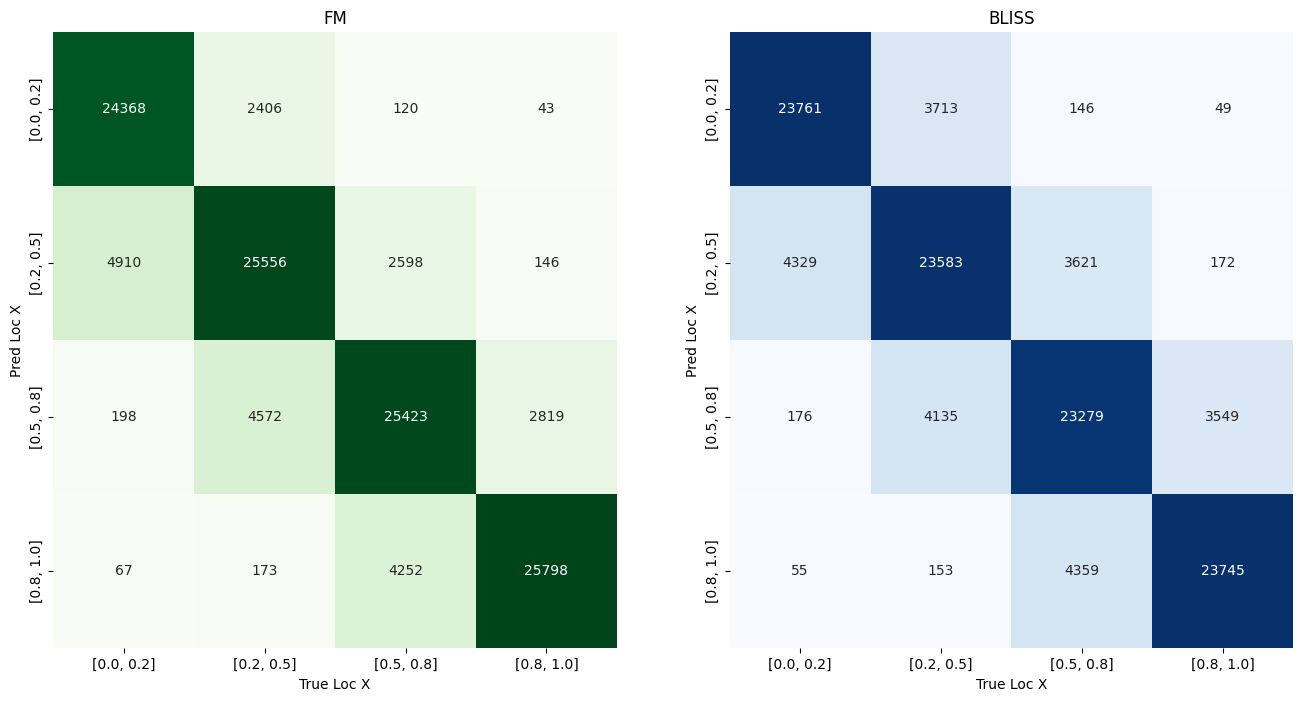

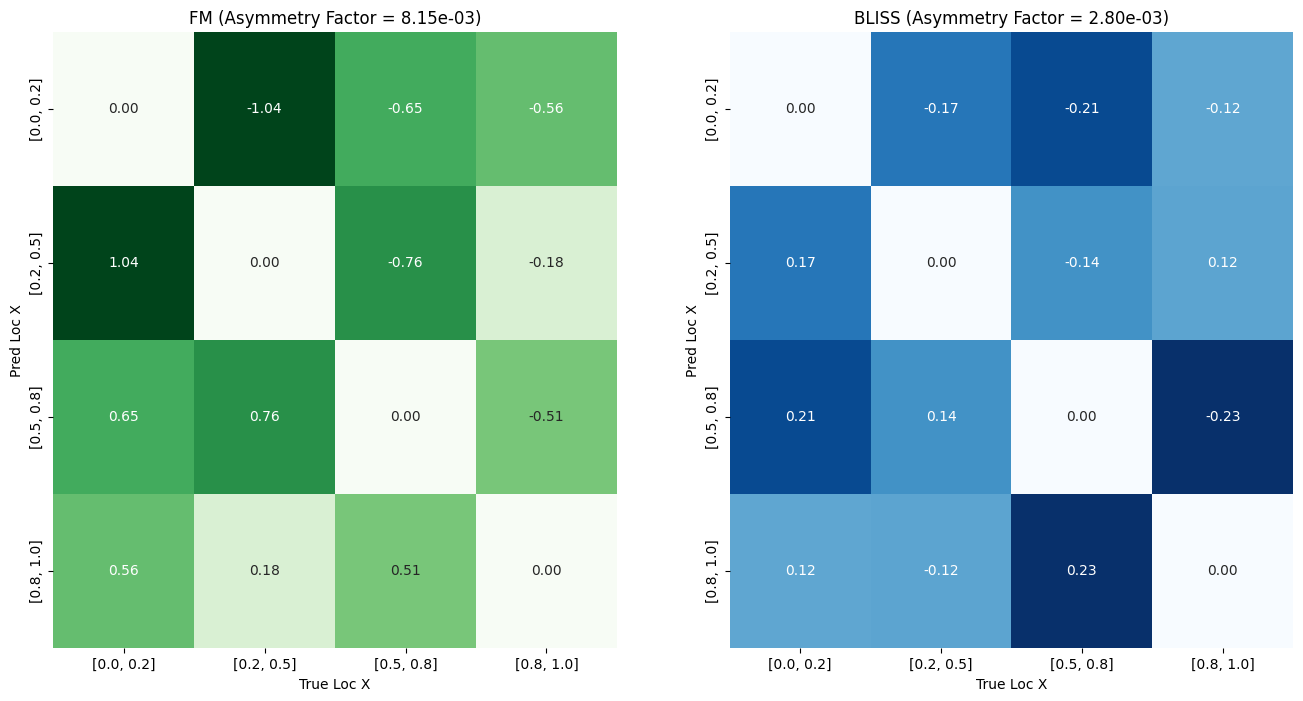

In [33]:
locs_bin_boundary = torch.linspace(0.0, 1.0, 5)
d_pred_locs_x_bin_index = inclusive_bucektize(diffusion_pred_locs[diffusion_valid_source_mask][:, 1], 
                                              locs_bin_boundary)
d_true_locs_x_bin_index = inclusive_bucektize(diffusion_true_locs[diffusion_valid_source_mask][:, 1], 
                                              locs_bin_boundary)
b_pred_locs_x_bin_index = inclusive_bucektize(bliss_pred_locs[bliss_valid_source_mask][:, 1], 
                                              locs_bin_boundary)
b_true_locs_x_bin_index = inclusive_bucektize(bliss_true_locs[bliss_valid_source_mask][:, 1], 
                                              locs_bin_boundary)
# d_pred_locs_x_bin_index = inclusive_bucektize(diffusion_pred_locs[:, 1], 
#                                               locs_bin_boundary)
# d_true_locs_x_bin_index = inclusive_bucektize(diffusion_true_locs[:, 1], 
#                                               locs_bin_boundary)
# b_pred_locs_x_bin_index = inclusive_bucektize(bliss_pred_locs[:, 1], 
#                                               locs_bin_boundary)
# b_true_locs_x_bin_index = inclusive_bucektize(bliss_true_locs[:, 1], 
#                                               locs_bin_boundary)
plot_cm(d_pred_locs_x_bin_index, d_true_locs_x_bin_index,
        b_pred_locs_x_bin_index, b_true_locs_x_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc X")

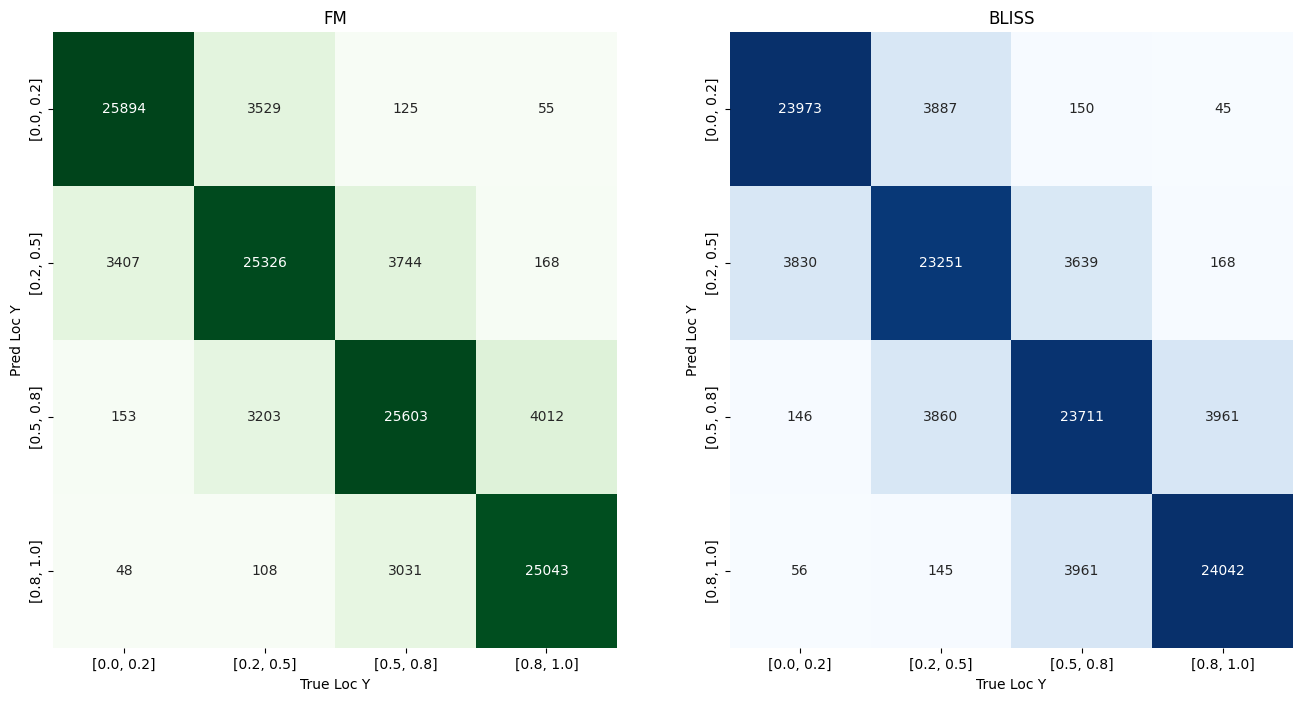

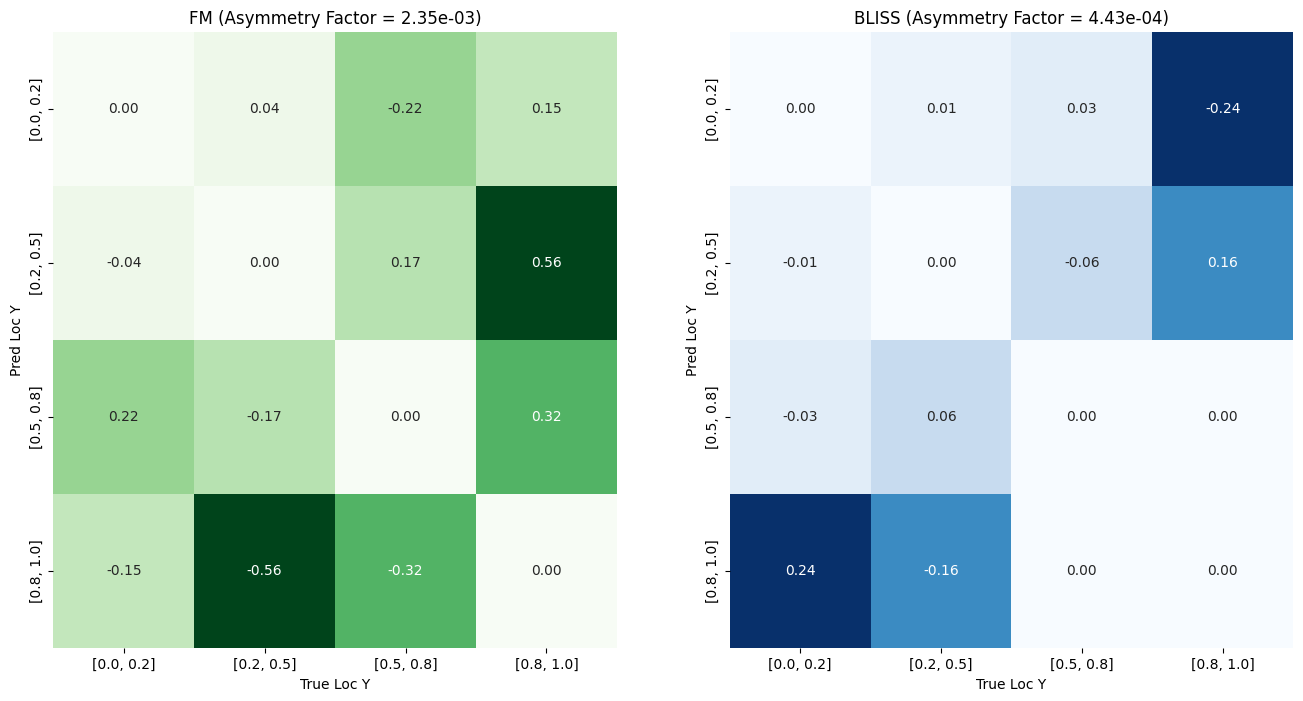

In [34]:
locs_bin_boundary = torch.linspace(0.0, 1.0, 5)
d_pred_locs_y_bin_index = inclusive_bucektize(diffusion_pred_locs[diffusion_valid_source_mask][:, 0], 
                                              locs_bin_boundary)
d_true_locs_y_bin_index = inclusive_bucektize(diffusion_true_locs[diffusion_valid_source_mask][:, 0], 
                                              locs_bin_boundary)
b_pred_locs_y_bin_index = inclusive_bucektize(bliss_pred_locs[bliss_valid_source_mask][:, 0], 
                                              locs_bin_boundary)
b_true_locs_y_bin_index = inclusive_bucektize(bliss_true_locs[bliss_valid_source_mask][:, 0], 
                                              locs_bin_boundary)
plot_cm(d_pred_locs_y_bin_index, d_true_locs_y_bin_index,
        b_pred_locs_y_bin_index, b_true_locs_y_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc Y")

## Fluxes

In [35]:
diffusion_true_fluxes = []
diffusion_pred_fluxes = []
for true1_f, true2_f, pred_f in zip(diffusion_result_dict["target1_fluxes_list"],
                                    diffusion_result_dict["target2_fluxes_list"],
                                    diffusion_result_dict["pred_fluxes_list"],
                                    strict=True):
    true_f = torch.cat([true1_f, true2_f], dim=-2) 
    diffusion_pred_fluxes.append(pred_f)
    diffusion_true_fluxes.append(true_f)
diffusion_true_fluxes = torch.cat(diffusion_true_fluxes, dim=0)
diffusion_pred_fluxes = torch.cat(diffusion_pred_fluxes, dim=0)

In [36]:
diffusion_true_fluxes.shape, diffusion_pred_fluxes.shape

(torch.Size([25000, 20, 20, 2, 6]), torch.Size([25000, 20, 20, 2, 6]))

In [37]:
bliss_true_fluxes = []
bliss_pred_fluxes = []
for true1_f, true2_f, pred_f in zip(bliss_result_dict["target1_fluxes_list"],
                                    bliss_result_dict["target2_fluxes_list"],
                                    bliss_result_dict["pred_fluxes_list"],
                                    strict=True):
    true_f = torch.cat([true1_f, true2_f], dim=-2) 
    bliss_pred_fluxes.append(pred_f)
    bliss_true_fluxes.append(true_f)
bliss_true_fluxes = torch.cat(bliss_true_fluxes, dim=0)
bliss_pred_fluxes = torch.cat(bliss_pred_fluxes, dim=0)

In [38]:
bliss_true_fluxes.shape, bliss_pred_fluxes.shape

(torch.Size([25000, 20, 20, 2, 6]), torch.Size([25000, 20, 20, 2, 6]))

In [39]:
# diffusion_pred_fluxes[diffusion_valid_source_mask].quantile(torch.tensor([1e-4, 1e-3, 0.01, 0.1, 0.5, 0.9, 0.99]))

In [40]:
# diffusion_true_fluxes[diffusion_valid_source_mask].quantile(torch.tensor([1e-4, 1e-3, 0.01, 0.1, 0.5, 0.9, 0.99]))

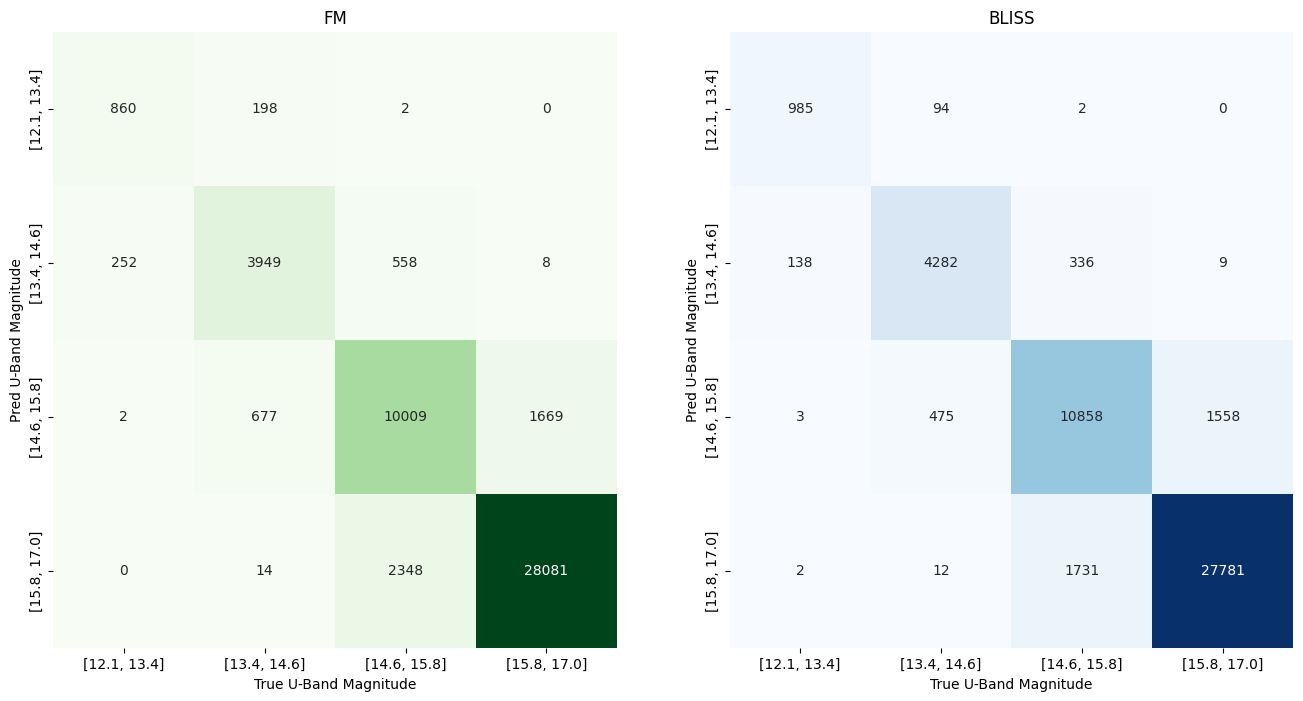

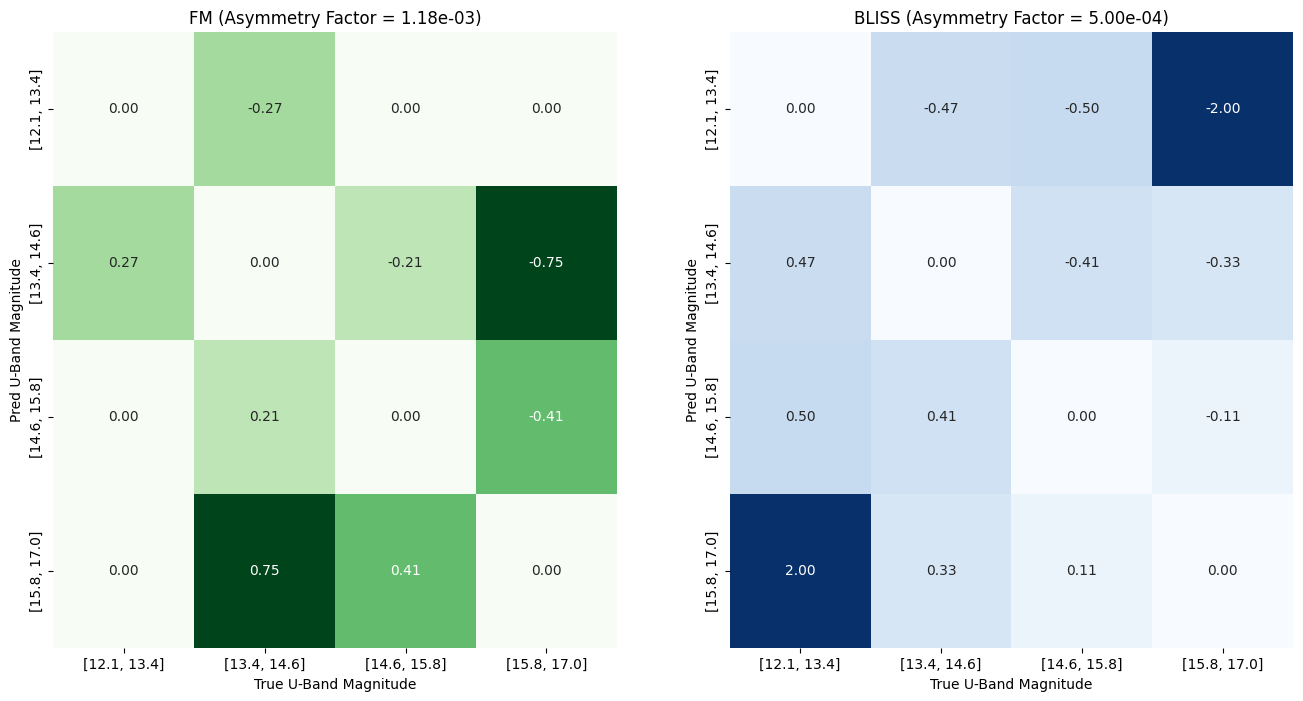

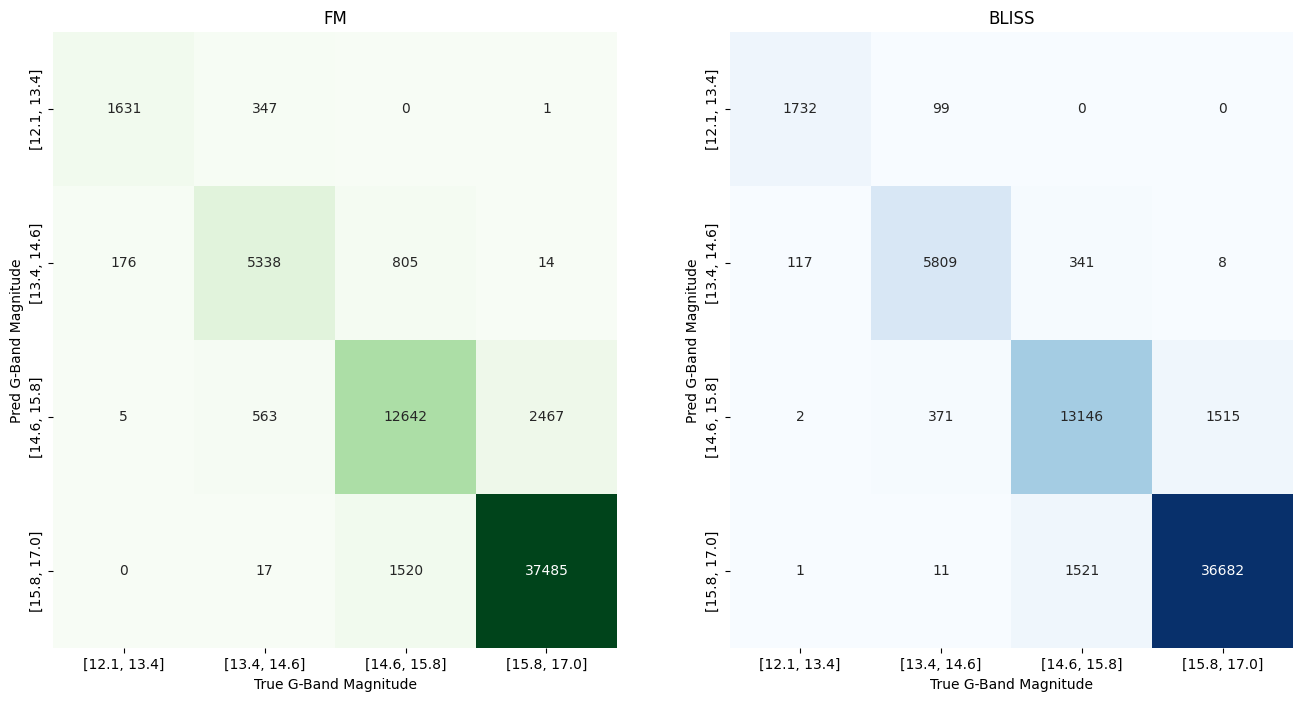

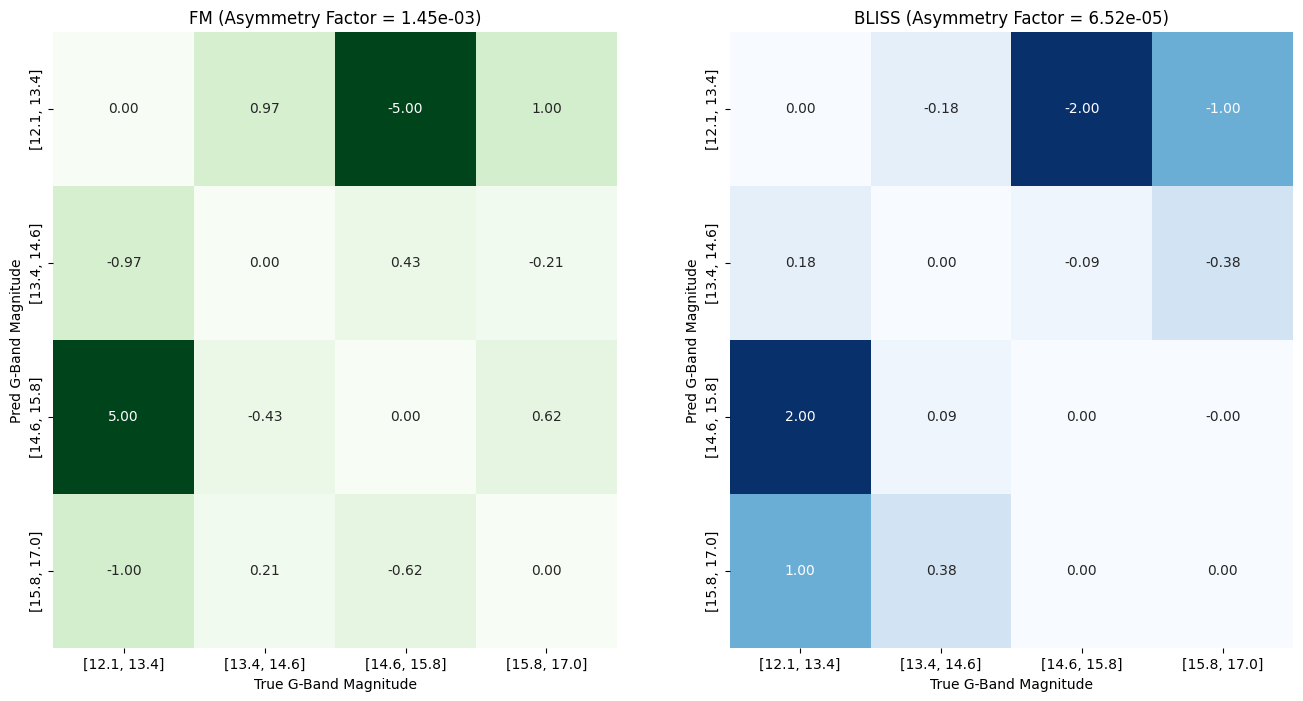

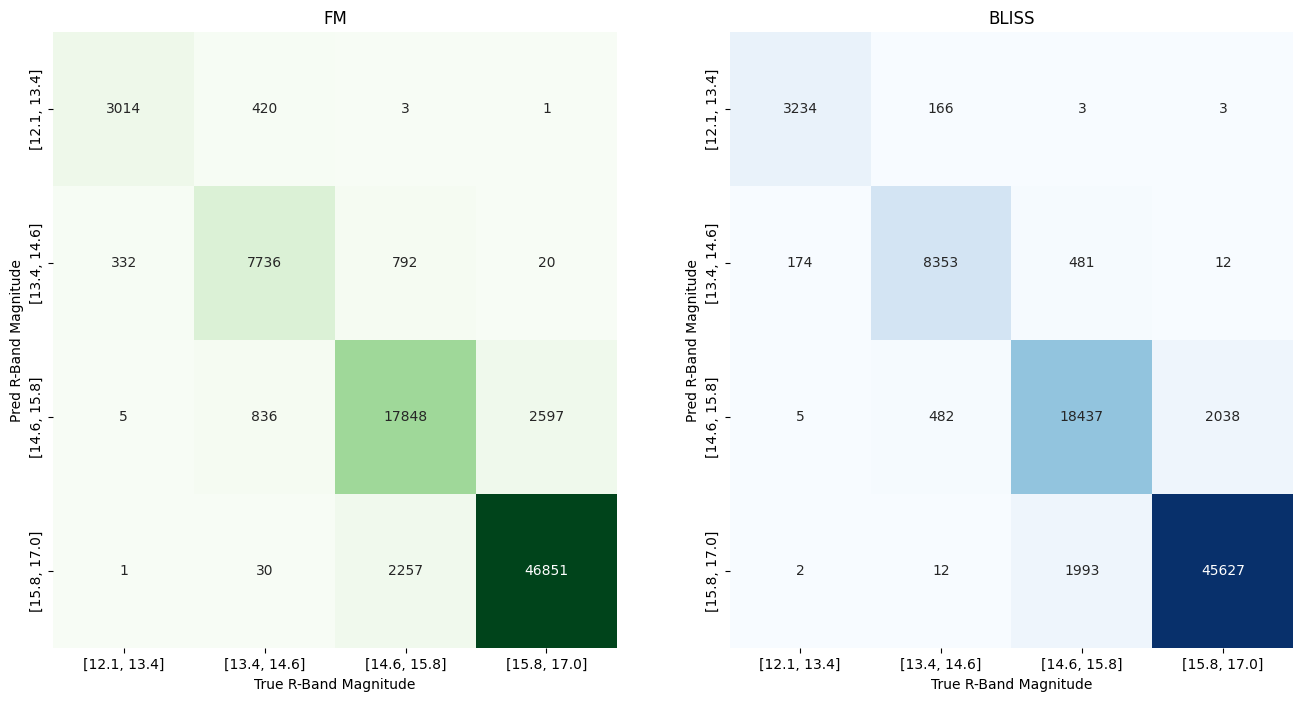

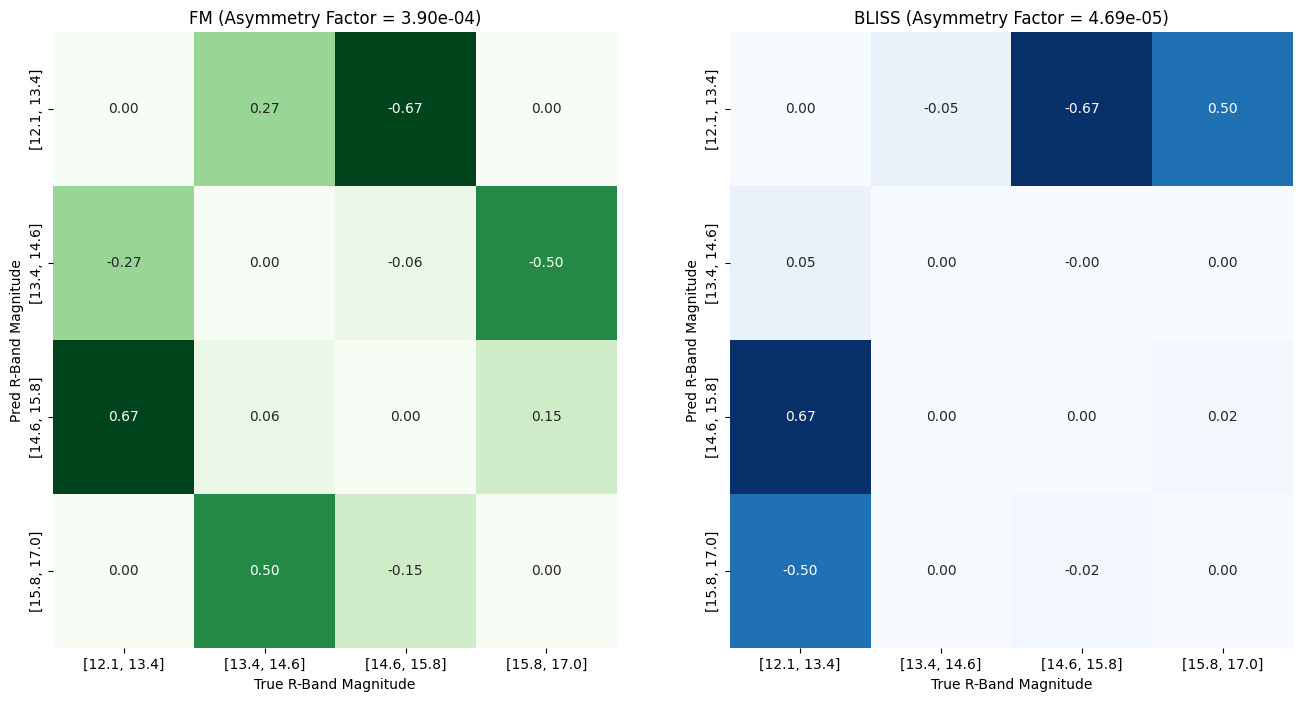

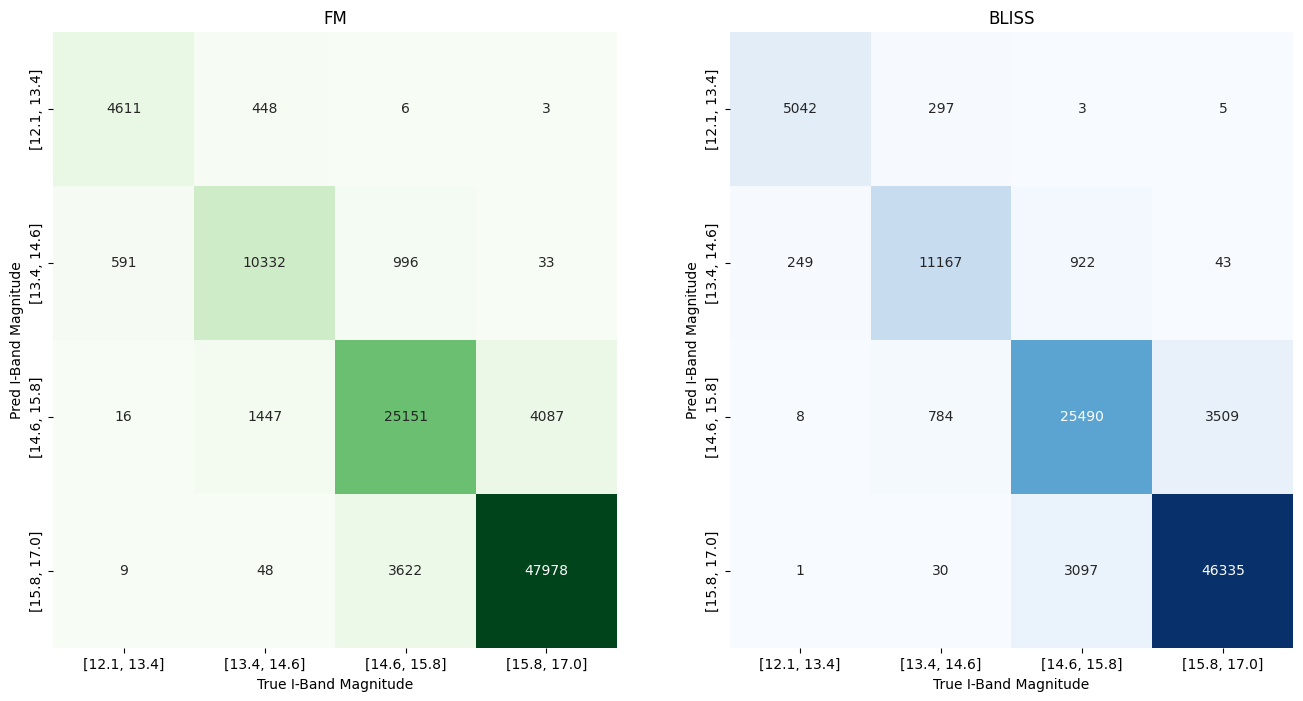

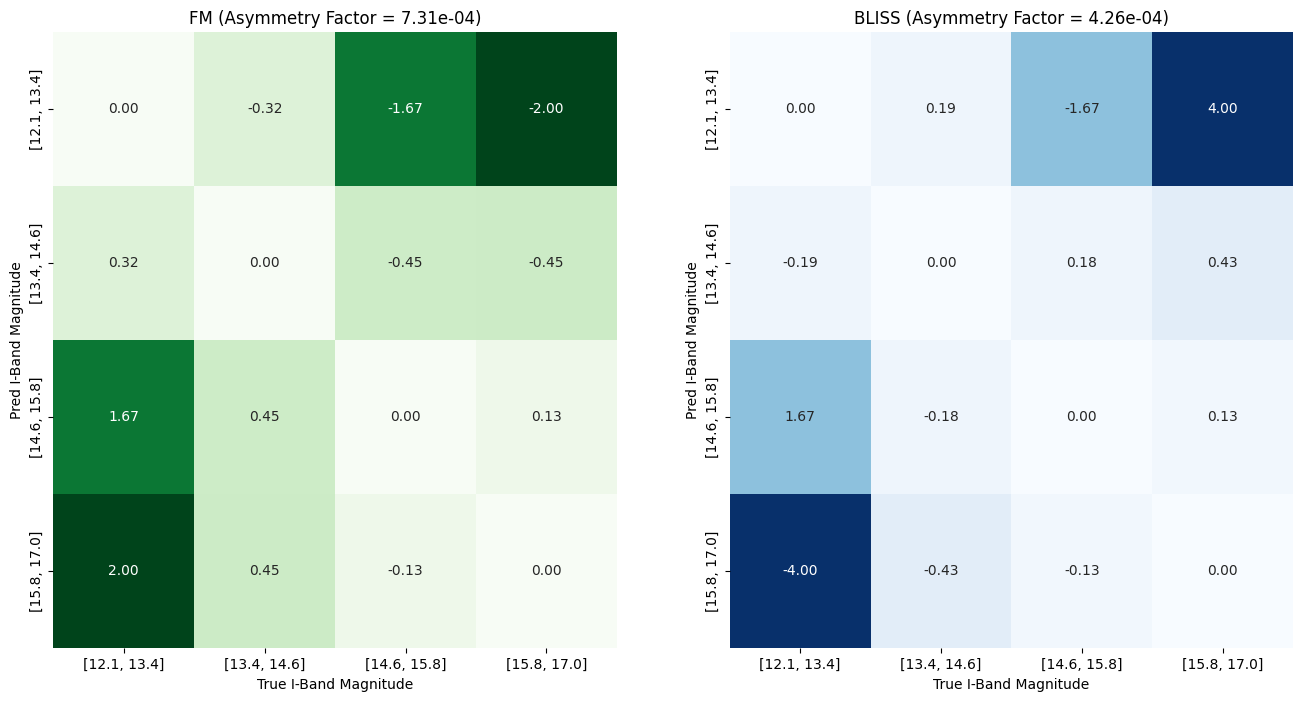

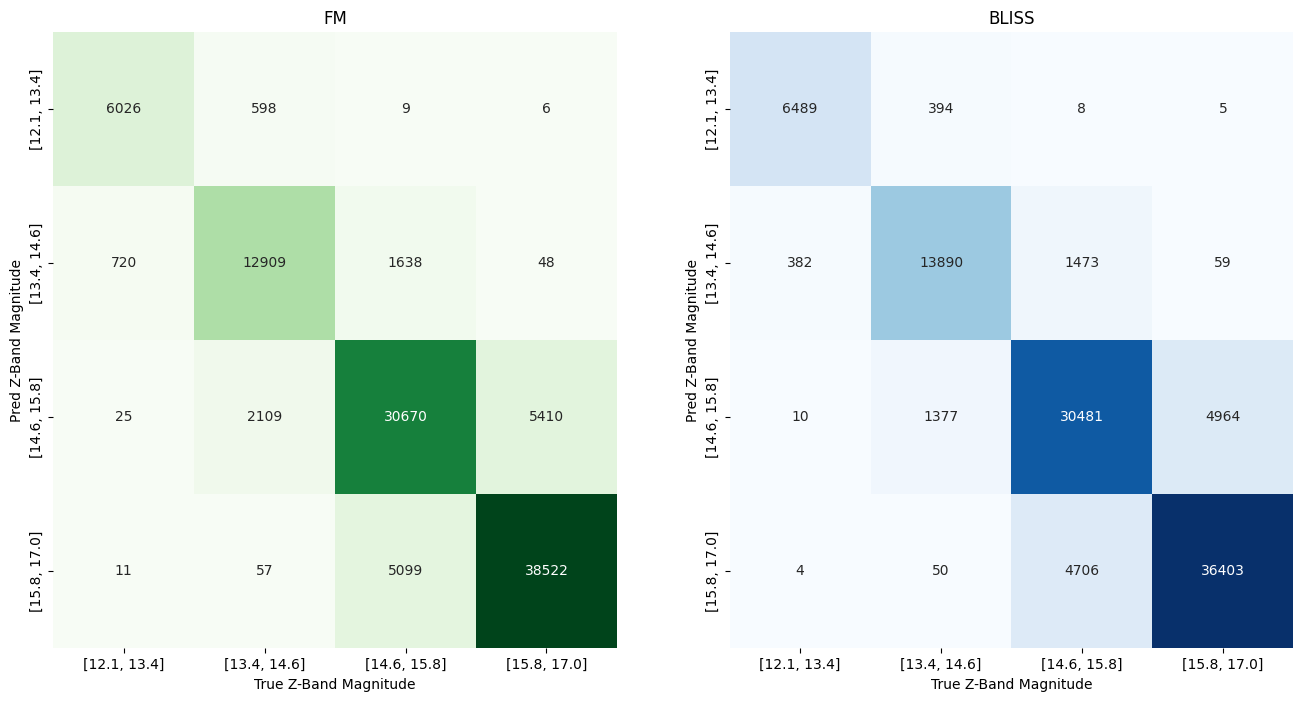

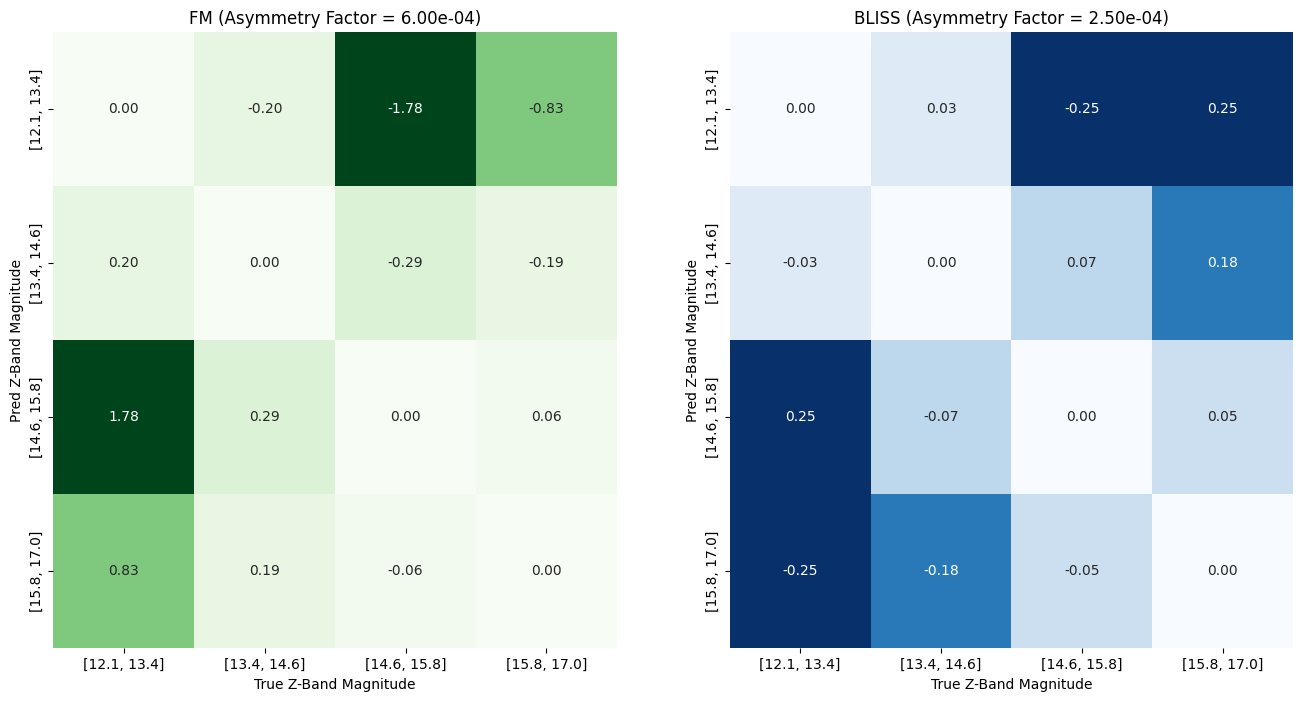

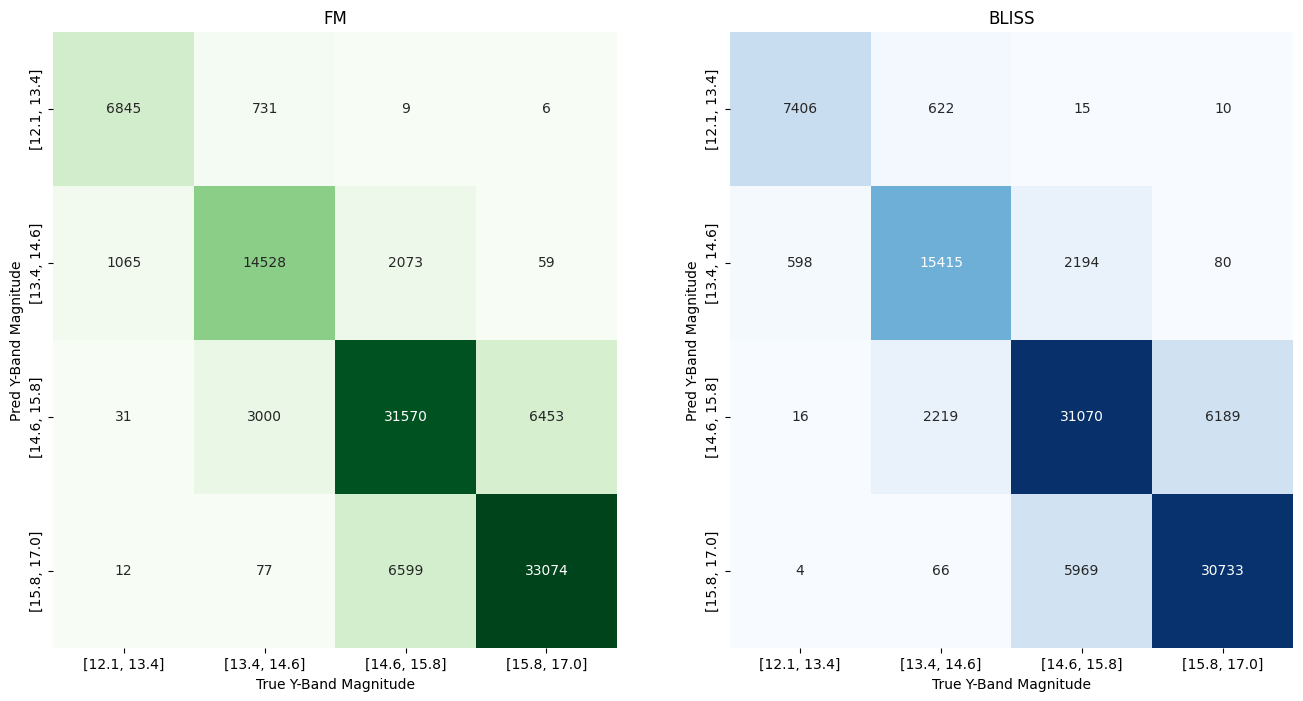

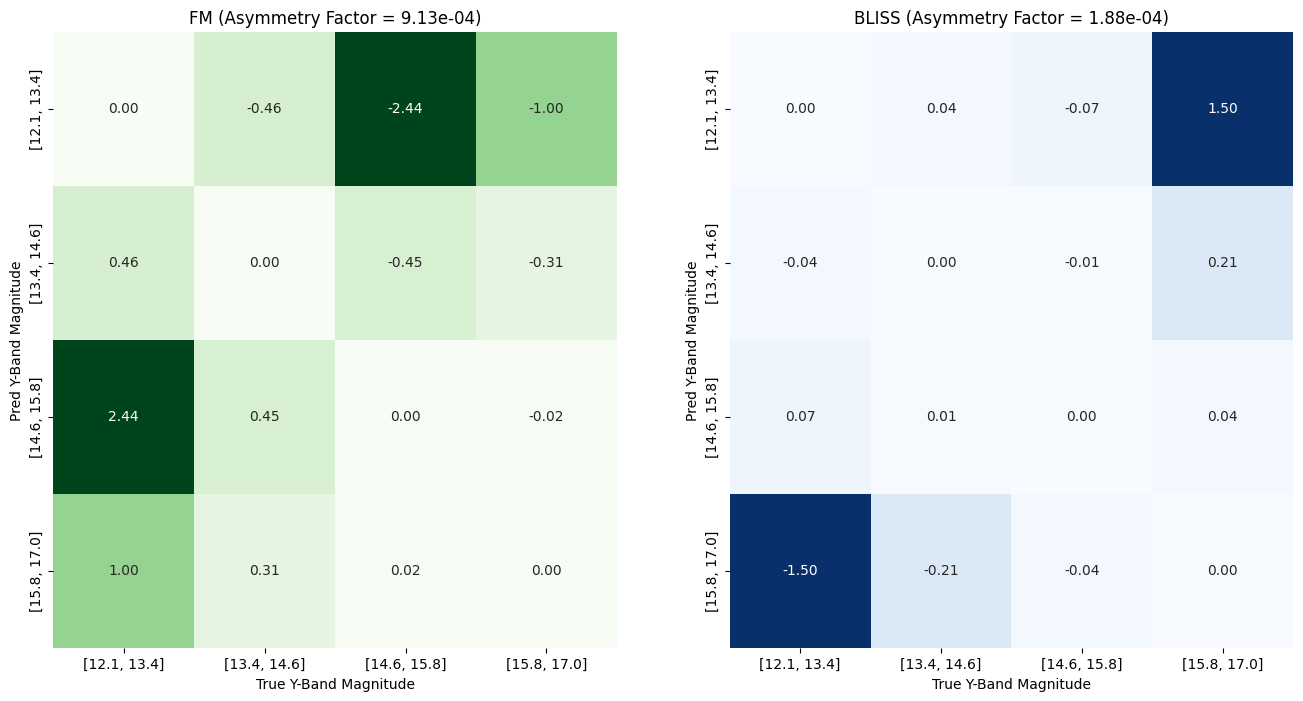

In [41]:
for i, band_name in enumerate("ugrizy"):
        d_pred_m = convert_flux_to_magnitude(diffusion_pred_fluxes[..., i].clamp(min=100.0), zero_point=1e9)
        d_true_m = convert_flux_to_magnitude(diffusion_true_fluxes[..., i].clamp(min=100.0), zero_point=1e9)
        b_pred_m = convert_flux_to_magnitude(bliss_pred_fluxes[..., i].clamp(min=100.0), zero_point=1e9)
        b_true_m = convert_flux_to_magnitude(bliss_true_fluxes[..., i].clamp(min=100.0), zero_point=1e9)

        min_m = max(d_true_m.min().item(), b_true_m.min().item()) + 0.5
        max_m = min(d_true_m.max().item(), b_true_m.max().item()) - 0.5

        fluxes_bin_boundaries = torch.linspace(min_m, max_m, 5)
        fluxes_bins = list(zip(fluxes_bin_boundaries[:-1], fluxes_bin_boundaries[1:]))
        d_pred_m_bin_indexes = torch.bucketize(d_pred_m[diffusion_valid_source_mask], fluxes_bin_boundaries)
        d_true_m_bin_indexes = torch.bucketize(d_true_m[diffusion_valid_source_mask], fluxes_bin_boundaries)
        b_pred_m_bin_indexes = torch.bucketize(b_pred_m[bliss_valid_source_mask], fluxes_bin_boundaries)
        b_true_m_bin_indexes = torch.bucketize(b_true_m[bliss_valid_source_mask], fluxes_bin_boundaries)

        plot_cm(d_pred_m_bin_indexes, d_true_m_bin_indexes,
                b_pred_m_bin_indexes, b_true_m_bin_indexes,
                bin_num=6, bin_labels=[f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in fluxes_bins],
                axis_label=f"{band_name.upper()}-Band Magnitude", exclude_first_and_last_bins=True)